# Geospatial Python
## Accessing satellite imagery using Python
Setup: https://carpentries-incubator.github.io/geospatial-python/index.html

Instruction: https://carpentries-incubator.github.io/geospatial-python/05-access-data.html

Objectives:
* Search public [SpatioTemporal Asset Catalog (STAC)](https://github.com/radiantearth/stac-api-spec/tree/release/v1.0.0) repositories of satellite imagery using Python.
* Inspect search result’s metadata.
* Download (a subset of) the assets available for a satellite scene.
* Open satellite imagery as raster data and save it to disk.

### SpatioTemporal Asset Catalog (STAC) specification 

- Terabytes of data products are added daily to the satellite collections 
- Downloading these data to your local hard drive is not practical 
- Graphical User Interfaces (GUIs) are often available allowing online exploration  
  - E.g https://dataspace.copernicus.eu/browser/ 
- Drawbacks to manually downloading: 
  - Easy to miss items	 
  - Not easily reproducible 



- Benefits of retrieving data programmatically:
  * More reliable
  * Scalable 
  * Reproducible	

In [1]:
# First import necessary libraries
import rioxarray # to open and download remote raster data
from pystac_client import Client# to query STAC API endpoint

from shapely.geometry import Point # to create a point 
import geojson # to parse spatial data
import folium # to create an interactive map
from folium.plugins import Draw # to allow drawing

# Create a variable to determine if the notebook is being run locally
local_run=False
if local_run:
    # this package is problematic on remote computers
    from localtileserver import TileClient, get_folium_tile_layer # to visualize the geotiff

In [2]:
# Create an interactive map for use in creating a point of interest (POI)

# Start by defining a point to center the map on
center_coord = [40.60104027382292, -105.09137099497742] # fort collins

# Create the map
m  = folium.Map(center_coord, zoom_start=5)

# Add drawing controls
draw = Draw(export=True)
draw.add_to(m)

m

# Use the drawing tools to create a POI
# Click the POI to get the coordinates (e.g numbers between '[' and ']'.

In [3]:
# Go to https://radiantearth.github.io/stac-browser/
# Search for the "earth search"
# Click the link

# Then from the Earth Search page, click the "Source" button, and copy the URL from the text field

# Paste the Earth Search STAC catalog API URL below
api_url = "https://earth-search.aws.element84.com/v1"

# Open the API
client = Client.open(api_url)

In [4]:
# Perform a metadata search 
# limited to 10 results from Sentinel-2, Level 2A, to retrieve Cloud Optimized GeoTiffs (COGs)

# Store a variable pointing to the collection of interest
# Note: Collection ID is taken from Sentinel-2 Level 2A - https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a
collection = "sentinel-2-l2a" 
'''
This collection includes Sentinel-2 data products 
pre-processed at level 2A (bottom-of-atmosphere reflectance) 
and saved in Cloud Optimized GeoTIFF (COG) format
'''

# Create a point to search from
# Note: values are in format x (long), y (lat) https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html
point = Point(-105.275116,40.605531,)  # From interactive map above 
# Alternatively use https://www.google.com/maps > search for place > right click to access lat and lng
# lat (y) usually displayed before lng x, lng goes from -180 (west of Greenwich) - 0 - 180

# Perform the search
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10,
)
# show the number of scenes (i.e. the portion of the footage recorded by the satellite)
print(search.matched())

1305


In [5]:
# Store the metadata of the search results
items = search.item_collection()

In [6]:
# Get the length of items
print(len(items))

10


In [7]:
# Loop over the items to see there ids
for item in items:
    print(item)

<Item id=S2A_13TDE_20240714_0_L2A>
<Item id=S2A_13TDF_20240714_0_L2A>
<Item id=S2B_13TDE_20240709_0_L2A>
<Item id=S2B_13TDF_20240709_0_L2A>
<Item id=S2A_13TDE_20240704_0_L2A>
<Item id=S2A_13TDF_20240704_0_L2A>
<Item id=S2B_13TDE_20240629_0_L2A>
<Item id=S2B_13TDF_20240629_0_L2A>
<Item id=S2A_13TDE_20240624_0_L2A>
<Item id=S2A_13TDF_20240624_0_L2A>


In [8]:
# Inspect the metadata associated with the first item of the search results
item = items[0]
print(item.datetime)
print(item.geometry)
print(item.properties)

2024-07-14 18:02:57.459000+00:00
{'type': 'Polygon', 'coordinates': [[[-106.18316062292897, 40.64478591807637], [-106.1661201925584, 39.65576169772817], [-104.88623172845638, 39.661560248682505], [-104.88456877606482, 40.650789813976196], [-106.18316062292897, 40.64478591807637]]]}
{'created': '2024-07-15T03:08:12.936Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 26.527882, 'proj:epsg': 32613, 'mgrs:utm_zone': 13, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'DE', 'grid:code': 'MGRS-13TDE', 'view:sun_azimuth': 138.569243232913, 'view:sun_elevation': 66.780875556989, 's2:degraded_msi_data_percentage': 0.1335, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 1.085574, 's2:cloud_shadow_percentage': 5.232886, 's2:vegetation_percentage': 32.808819, 's2:not_vegetated_percentage': 29.285401, 's2:water_percentage': 0.889224, 's2:unclassified_percentage': 4.064101, 's2:medium_

In [9]:
'''
EXERCISE: Search the sentinel-2-l2a collection for all the available scenes that satisfy the following criteria: 
- intersect a provided bounding box (use ±0.01 deg in lat/lon from the previously defined point); 
- have been recorded between 20 March 2020 and 30 March 2020; 
- have a cloud coverage less than 15. Note: the eo extension (https://github.com/stac-extensions/eo) is implemented in some collections allowing it to be queried against

* Get the count
* Save the results to json
'''
bbox = point.buffer(0.01).bounds

search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2023-03-20/2024-03-30",
    query=["eo:cloud_cover<15"]
)
print(search.matched())
items = search.item_collection()
items.save_object("search.json") # json file saved alongside notebook

47


## Access the assets


In [10]:
# Get the first item's assets
assets = items[0].assets  

print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [11]:
# Print a minimal description of the available assets
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

In [12]:
# Show one metadata value
print(assets["thumbnail"])
print(assets["thumbnail"].href)

<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/T/DE/2024/3/S2B_13TDE_20240321_0_L2A/thumbnail.jpg>
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/T/DE/2024/3/S2B_13TDE_20240321_0_L2A/thumbnail.jpg


In [13]:
# Open 'nir' with the rioxarray library
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href, overview_level=3)
print(nir)

<xarray.DataArray (band: 1, y: 687, x: 687)> Size: 944kB
[471969 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB 4e+05 4.002e+05 ... 5.095e+05 5.097e+05
  * y            (y) float64 5kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


In [14]:
# save whole image to disk - this may take awhile
# Actually, let's not, as this is a large file
# nir.rio.to_raster("nir.tif")

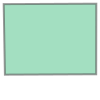

In [15]:
# Let's show the boundary box of the whole tiff on an interactive map
# Interactive maps generally expect data that's in CRS 4326
# We'll need to convert our boundary box to this CRS

# Some extra modules and a library are required for this
from shapely.geometry import box # To create a box
from shapely.ops import transform # The shapely transform module  
import pyproj # A reprojection library

# Create the transformer
project = pyproj.Transformer.from_crs(nir.rio.crs.to_epsg(), 4326, always_xy=True).transform

# Create our boundary box
bbox = box(*nir.rio.bounds())

# Apply the transformation
bbox_transformed = transform(project, bbox)

bbox_transformed


In [16]:
# Let's use an interctive map to create an area of interest (AOI) for use in subsetting our data. 

# Create and center our map to the our POI
m = folium.Map(location=[point.y,point.x], zoom_start=12)

# Create tiles client
if local_run:
    # Geotiff files will not show in our web browser, but we can convert them on-the-fly
    # We'll use a library that goes one step further, and generates map tiles.
    # Map tiles allow us to only load in the part of the image we are intersted in when moving around the map
    nir_tiles = TileClient(nir_href) 
    nir_layer = get_folium_tile_layer(nir_tiles, name='nir') # create elevation tile layer
    nir_layer.add_to(m)

# show the boundary box of the whole tiff
folium.GeoJson(bbox_transformed,
    style_function=lambda feature: {
        "color": "red",
    }).add_to(m)


draw = Draw(export=True)
draw.add_to(m)

# add a layer control to toggle layers
folium.LayerControl().add_to(m)
m

# Use the draw rectangle tool to create a shape that overlaps a portion of the boundary

In [17]:
# Save a portion of the raster to disk

# Copy the geojson from the drawn polygon (click the shape, and copy the text starting from '{"type":"Polygon"', up until the last '}').
geom='''{"type":"Polygon","coordinates":[[[-106.001587,39.905523],[-106.001587,40.233412],[-104.952393,40.233412],[-104.952393,39.905523],[-106.001587,39.905523]]]}'''
geojson.loads(geom)
cropping_geometries = [geojson.loads(geom)] # converts to list

# Use .rio.clip to subset the raster data
# Doc: https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-rio-accessors
nir_sub = nir.rio.clip(geometries=cropping_geometries, crs=4326)
nir_sub.rio.to_raster("output_data/nir_subset.tif")

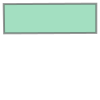

In [18]:
# We'll also show the boundary box of the subset tiff on an interactive map
# This too will require reprojecting our boundary box
bbox_clip = box(*rioxarray.open_rasterio("output_data/nir_subset.tif").rio.bounds())
bbox_clip_transformed = transform(project, bbox_clip)

bbox_clip_transformed

In [19]:
# Create an interctive map showing our AOI and subsetted raster

m = folium.Map(location=[point.y,point.x], zoom_start=12)

if local_run:
    nir_tiles = TileClient("output_data/nir_subset.tif") # create tiles client
    nir_layer = get_folium_tile_layer(nir_tiles, name='nir')
    nir_layer.add_to(m)

# show the boundary box of the whole tiff
folium.GeoJson(bbox_transformed,
    style_function=lambda feature: {
        "color": "red",
    }).add_to(m)

# show the boundary box of the clipped tiff
folium.GeoJson(bbox_clip_transformed,
    style_function=lambda feature: {
        "color": "green",
    }).add_to(m)

# show our drawn polygon
folium.GeoJson(geom).add_to(m)



folium.LayerControl().add_to(m)

m